In [7]:
import os
import signal
import sys
import time

import example_robot_data
import numpy as np
import pinocchio

import crocoddyl
from crocoddyl.utils.quadruped import SimpleQuadrupedalGaitProblem, plotSolution
from schaeffler2025.meshcat_viewer_wrapper import MeshcatVisualizer


In [8]:
robot = example_robot_data.load("go2")
robot_model = robot.model
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


In [9]:
viz.viewer.jupyter_cell()

In [11]:
lims = robot_model.effortLimit
lims *= 0.5  # reduced artificially the torque limits
robot_model.effortLimit = lims

# Setting up the 3d walking problem
lfFoot, rfFoot, lhFoot, rhFoot = "LF_FOOT", "RF_FOOT", "LH_FOOT", "RH_FOOT"
gait = SimpleQuadrupedalGaitProblem(robot_model, lfFoot, rfFoot, lhFoot, rhFoot)

# Defining the initial state of the robot
q0 = robot_model.referenceConfigurations["standing"].copy()
v0 = pinocchio.utils.zero(robot_model.nv)
x0 = np.concatenate([q0, v0])

# Defining the walking gait parameters
walking_gait = {
    "stepLength": 0.25,
    "stepHeight": 0.25,
    "timeStep": 1e-2,
    "stepKnots": 25,
    "supportKnots": 2,
}

problem = gait.createWalkingProblem(
        x0,
        walking_gait["stepLength"],
        walking_gait["stepHeight"],
        walking_gait["timeStep"],
        walking_gait["stepKnots"],
        walking_gait["supportKnots"],
    )


IndexError: Index out of range

In [5]:

# Setting up the control-limited DDP solver
# solver = crocoddyl.SolverBoxDDP(problem)
solver = crocoddyl.SolverDDP(problem)
solver.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
# conv = ddp.solve(init_us=list(u_nom), init_xs=list(x_nom), maxiter=30)
solver.solve()

# Add the callback functions
# solver.setCallbacks([crocoddyl.CallbackVerbose(), crocoddyl.CallbackLogger()])

# # Solve the DDP problem
# # Initial state and control
# xs = [x0] * (solver.problem.T + 1)
# us = solver.problem.quasiStatic([x0] * solver.problem.T)
# # Solve
# solver.solve(xs, us, 100, False, 0.1)


iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  8.311e+06  0.000e+00  8.287e+06  1.657e+07  1.000e-08  1.000e-08  0.0020  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   1  8.311e+06  0.000e+00  8.287e+06  1.657e+07  1.000e-07  1.000e-07  0.0020  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   2  8.311e+06  0.000e+00  8.287e+06  1.657e+07  1.000e-06  1.000e-06  0.0020  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   3  8.311e+06  0.000e+00  8.287e+06  1.657e+07  1.000e-05  1.000e-05  0.0020  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   4  8.311e+06  0.000e+00  8.287e+06  1.657e+07  1.000e-04  1.000e-04  0.0020  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   5  8.311e+06  0.000e+00  8.287e+06  1.657e+07  1.000e-03  1.000e

True

  26  1.020e+03  0.000e+00  1.253e-11  2.506e-11  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.253e-11  8.640e-12  0.000e+00  0.000e+00


/home/tsreckovic/Code/ddp-vs-mppi/.venv/lib/python3.12/site-packages/cmeel.prefix/lib/python3.12/site-packages/crocoddyl/__init__.py:1051: UserWarning: Ignoring specified arguments in this call because figure with num: 2 already exists
  plt.figure(figIndex, figsize=(6.4, 8))


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/
Opening in existing browser session.


KeyboardInterrupt: 

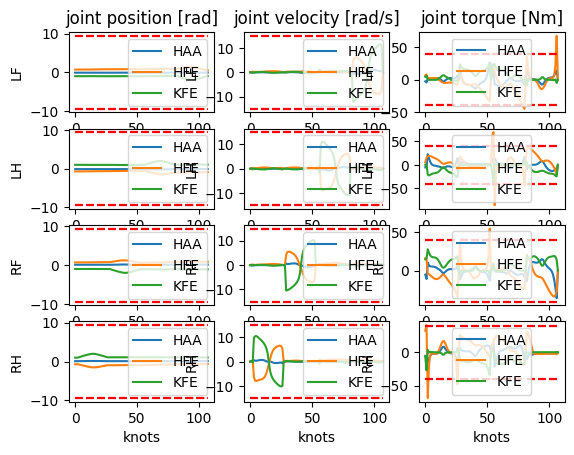

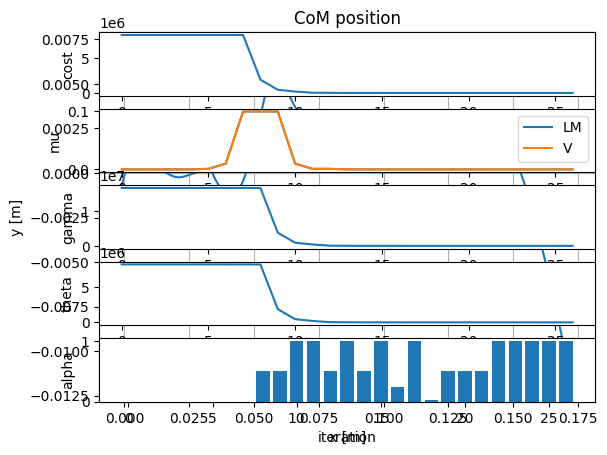

In [6]:
#  Plotting the entire motion
# Plot control vs limits
plotSolution(solver, bounds=True, figIndex=1, show=False)

# Plot convergence
log = solver.getCallbacks()[0]
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)

# Display the entire motion
# if WITHDISPLAY:

display = crocoddyl.MeshcatDisplay(robot)
display.rate = -1
display.freq = 1
while True:
    display.displayFromSolver(solver)
    time.sleep(1.0)